# Getting Started with Temporian

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/temporian/blob/main/docs/src/tutorials/toy_example.ipynb)

## Setup

In [1]:
# Skip this cell if you are running the notebook locally and have already installed temporian.
%pip install temporian


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import temporian as tp

import pandas as pd
import numpy as np

## Example Data

This minimal data consists of just one `signal` with a `timestamp` for each sample.

The signal is a periodic sinusoidal `season` with a slight positive slope in the long run, which we call `trend`. Plus the ubiquitous `noise`.

In [3]:
# Generate a synthetic dataset
timestamps = np.arange(0, 100, 0.1)
n = len(timestamps)
noise = 0.1 * np.random.randn(n)
trend = 0.01 * timestamps
season = 0.4 * np.sin(0.5 * timestamps)

raw_data = pd.DataFrame(
    {
        "timestamp": timestamps,
        "noise": noise,
        "trend": trend,
        "season": season,
        "signal": noise + trend + season,
    }
)

raw_data

,timestamp,noise,trend,season,signal
0,0.0,0.091299,0.000,0.000000,0.091299
1,0.1,-0.002616,0.001,0.019992,0.018375
2,0.2,0.057413,0.002,0.039933,0.099347
3,0.3,-0.070848,0.003,0.059775,-0.008073
4,0.4,-0.187095,0.004,0.079468,-0.103627
...,...,...,...,...,...
995,99.5,-0.137226,0.995,-0.197182,0.660592
996,99.6,0.028486,0.996,-0.179542,0.844944
997,99.7,-0.034614,0.997,-0.161453,0.800933
998,99.8,0.035802,0.998,-0.142960,0.890842


## Part 1: Loading Data

Any kind of signal is represented in Temporian as a **collection of events**, using the `EventSet` object.

In this case there's no `indexes` because we only have one sequence.

Indices could be useful if we had multiple signals in parallel.
For example, imagine that we needed to work with signals from multiple sensor devices, or represent the sales from many stores or products: we could separate them by setting the correct features as indexes for each one.

In [4]:
# Convert the DataFrame into a Temporian EventSet
signals_evset = tp.from_pandas(raw_data)

signals_evset

indexes: []
features: [('noise', float64), ('trend', float64), ('season', float64), ('signal', float64)]
events:
     (1000 events):
        timestamps: [ 0.   0.1  0.2 ... 99.7 99.8 99.9]
        'noise': [ 0.0913 -0.0026  0.0574 ... -0.0346  0.0358 -0.1445]
        'trend': [0.    0.001 0.002 ... 0.997 0.998 0.999]
        'season': [ 0.      0.02    0.0399 ... -0.1615 -0.143  -0.1241]
        'signal': [0.0913 0.0184 0.0993 ... 0.8009 0.8908 0.7304]
memory usage: 40.8 kB

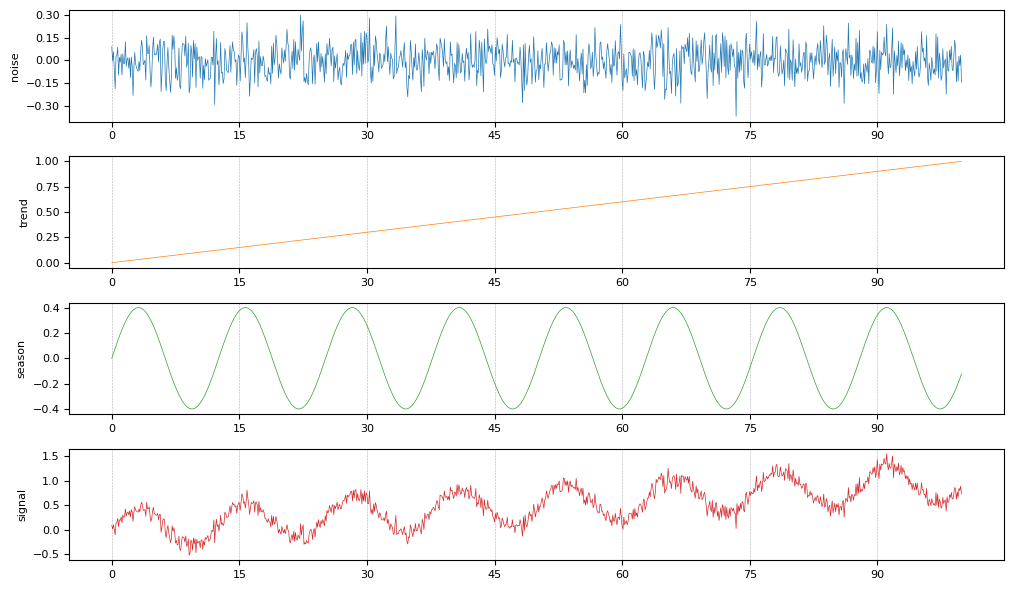

In [5]:
# Plot the dataset
_ = signals_evset.plot()

**Note:** If you're wondering why the plot has an empty `()` in the title, it's because we have no `indexes`, as mentioned above.

## Part 2: Using Operators

Now, we'll actually transform our temporal data using some operations:
- Using a moving average with a large window, the long-term `trend` slope is captured (sinusoid and noise average should be close to 0).
- The trend can be then subtracted from the original signal to get only the sinusoidal component `detrend`.

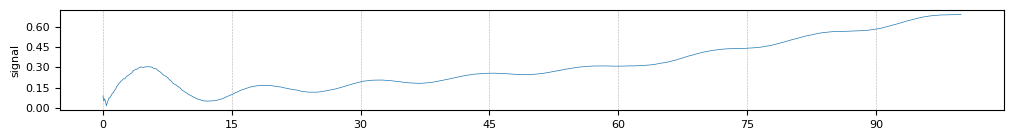

In [6]:
signal = signals_evset["signal"]
trend = signal.simple_moving_average(tp.duration.minutes(1))
trend.plot()

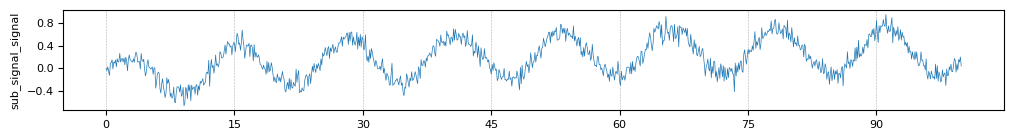

In [7]:
detrend = signal - trend
detrend.plot()

#### Feature naming
Did you notice the resulting feature names in the y-axis of the plots?

As you can see, the first moving average operation didn't change the feature name `signal` from the input, so `trend["signal"]` is the only output feature at that point. However, after the subtract operation, the resulting feature name is `sub_signal_signal`, which seems kinda weird in this case.

Actually, the naming criteria is not complicated, there are 2 rules:
- If the operator expects one single input (e.g: `simple_moving_average`), the output is a new `EventSet` with the same feature names as the only input.
- If the operator involves two inputs (e.g: arithmetics like `+-*/`), the output names are created by joining together the input feature names. For example, adding `evset[["f1", "f2"]] + evset[["f3", "f4"]]` results in a new `EventSet` with two features: `["add_f1_f3", "add_f2_f4"]`. Note that features are always added together by position, not by name.

So this name `sub_signal_signal` is the result of subtracting a feature named `signal` from another feature with the same name. We could have renamed the `trend["signal"]` feature to something better, to avoid this duplication. Let's do it now.

The `prefix()` operator might come handy to rename the `trend` feature. Check the output feature name in the plot.

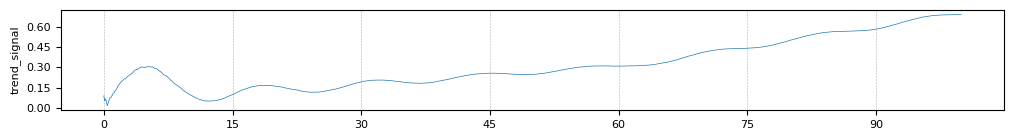

In [8]:
trend_prefix = trend.prefix("trend_")
trend_prefix.plot()

The `rename()` operator is also useful to avoid long feature names. Let's rename the `sub_signal_signal` feature to `detrend`:

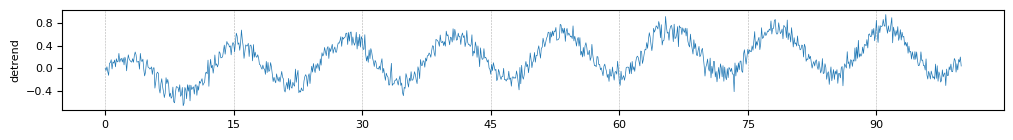

In [9]:
detrend_rename = detrend.rename("detrend")
detrend_rename.plot()

### Selecting and combining features

Features can be selected and combined to create new `EventSets` using two operations:
1. **Select:** using `evset["feature_1"]` or `evset[["feature_1", "feature_2"]]` will return a new `EventSet` object with only one or two features respectively.
1. **Glue:** using `tp.glue(evset_1, evset_2)` will return a new `EventSet` combining all features from both inputs. But the feature names cannot be repeated, so you may need to use `prefix()` or `rename()` before combining.

Let's add some operations and then plot together everything:
- The above de-trend process is repeated to refine the results in `trend2` and `detrend2`.
- The `slope` of one of the signals is calculated, by subtracting a delayed version of itself. Note that the time axis for this plot is shifted.

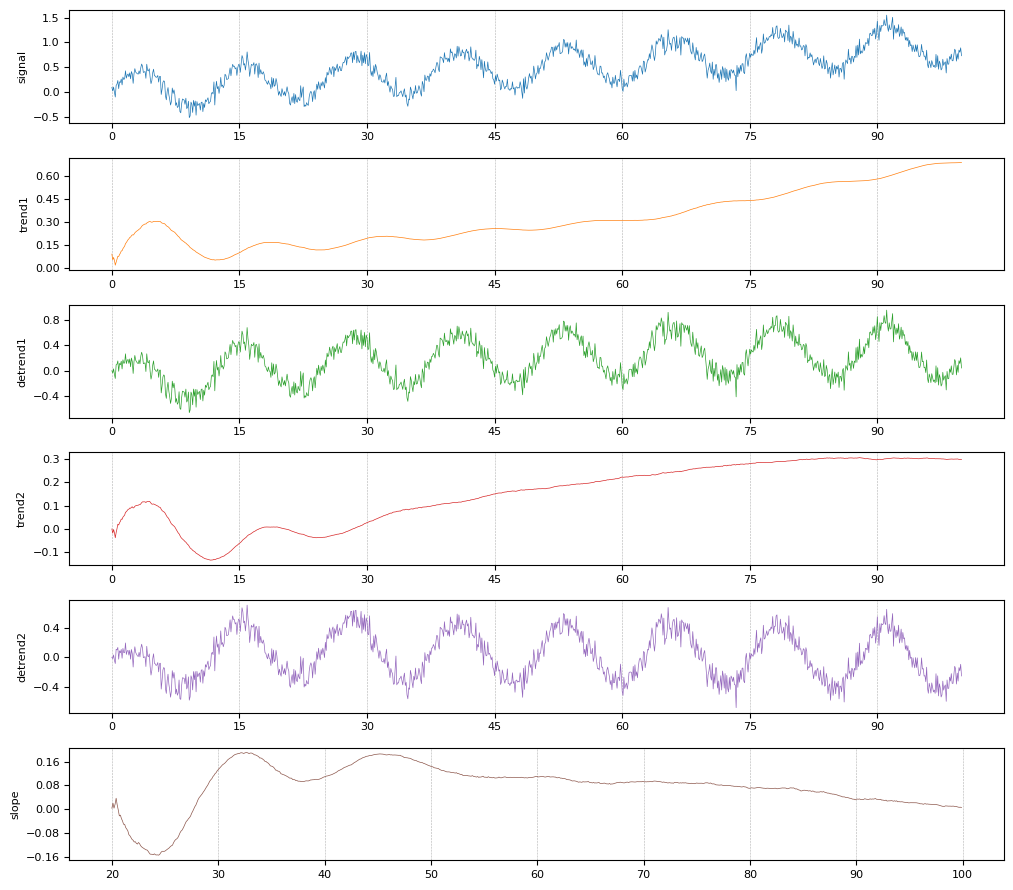

In [10]:
# Add some operations
trend2 = detrend.simple_moving_average(25)  # duration in seconds
detrend2 = detrend - trend2
slope = trend2 - trend2.lag(20).resample(trend2)

# Pack results to show all plots together
result_evset = tp.glue(
    signal,
    trend.rename("trend1"),
    detrend.rename("detrend1"),
    trend2.rename("trend2"),
    detrend2.rename("detrend2"),
    slope.rename("slope"),
)
result_evset.plot()

### Exporting outputs from Temporian
You may need to use this data in different ways for downstream tasks, like training a model using whatever library you need. 

If you can't use the data directly from Temporian, you can always go back to a pandas DataFrame:

In [11]:
tp.to_pandas(result_evset)

,signal,trend1,detrend1,trend2,detrend2,slope,timestamp
0,0.091299,0.091299,0.000000,0.000000,0.000000,NaN,0.0
1,0.018375,0.054837,-0.036462,-0.018231,-0.018231,NaN,0.1
2,0.099347,0.069674,0.029673,-0.002263,0.031936,NaN,0.2
3,-0.008073,0.050237,-0.058310,-0.016275,-0.042035,NaN,0.3
4,-0.103627,0.019464,-0.123091,-0.037638,-0.085453,NaN,0.4
...,...,...,...,...,...,...,...
995,0.660592,0.687107,-0.026515,0.298452,-0.324967,0.007746,99.5
996,0.844944,0.687383,0.157561,0.297757,-0.140196,0.006637,99.6
997,0.800933,0.687716,0.113217,0.297452,-0.184235,0.006241,99.7
998,0.890842,0.687752,0.203090,0.297963,-0.094873,0.006516,99.8


## Part 3: Using an index
This is the final important concept to get from this introduction.

Indexes are useful to handle multiple signals in parallel (as mentioned at the top of this notebook).
For example, working with signals from multiple sensor devices or representing sales from many stores or products. The feature names may be exactly the same for all the data, but we need to separate them by setting the correct `index` for each one.

### New example data: multiple devices
Let's create two signals with overlapping timestamps, with a different `signal_id`:

In [12]:
# Reuse raw_data to create one with two signals with overlapping timestamps
new_data = raw_data.copy()
new_data["trend"] *= 9
new_data["signal"] += new_data["trend"]

data_i1 = raw_data.copy()[:900]
data_i2 = new_data.copy()[300:]
data_i1["device_id"] = "Device 1"
data_i2["device_id"] = "Device 2"
data_2_devices = pd.concat([data_i1, data_i2])
data_2_devices

,timestamp,noise,trend,season,signal,device_id
0,0.0,0.091299,0.000,0.000000,0.091299,Device 1
1,0.1,-0.002616,0.001,0.019992,0.018375,Device 1
2,0.2,0.057413,0.002,0.039933,0.099347,Device 1
3,0.3,-0.070848,0.003,0.059775,-0.008073,Device 1
4,0.4,-0.187095,0.004,0.079468,-0.103627,Device 1
...,...,...,...,...,...,...
995,99.5,-0.137226,8.955,-0.197182,9.615592,Device 2
996,99.6,0.028486,8.964,-0.179542,9.808944,Device 2
997,99.7,-0.034614,8.973,-0.161453,9.773933,Device 2
998,99.8,0.035802,8.982,-0.142960,9.872842,Device 2


### EventSet with an index
Let's convert the dataframe to a Temporian `EventSet`, but this time specifying `indexes`, and see if the string representation makes sense now:

In [13]:
devices_evset = tp.from_pandas(data_2_devices, indexes=["device_id"])
devices_evset

indexes: [('device_id', str_)]
features: [('noise', float64), ('trend', float64), ('season', float64), ('signal', float64)]
events:
    device_id=b'Device 1' (900 events):
        timestamps: [ 0.   0.1  0.2 ... 89.7 89.8 89.9]
        'noise': [ 0.0913 -0.0026  0.0574 ...  0.0849 -0.1479 -0.0568]
        'trend': [0.    0.001 0.002 ... 0.897 0.898 0.899]
        'season': [0.     0.02   0.0399 ... 0.3051 0.3177 0.3294]
        'signal': [0.0913 0.0184 0.0993 ... 1.2871 1.0678 1.1716]
    device_id=b'Device 2' (700 events):
        timestamps: [30.  30.1 30.2 ... 99.7 99.8 99.9]
        'noise': [ 0.1521 -0.0129  0.0074 ... -0.0346  0.0358 -0.1445]
        'trend': [2.7   2.709 2.718 ... 8.973 8.982 8.991]
        'season': [ 0.2601  0.2446  0.2285 ... -0.1615 -0.143  -0.1241]
        'signal': [3.4122 3.2417 3.2558 ... 9.7739 9.8728 9.7214]
memory usage: 65.5 kB

As you can see above, each index has it's own timestamps and feature values. They will always have the same feature names though, because they're on the same `EventSet`.

The plots also accomodate to show each index separately. In particular, see below how the timestamps are different and partly overlapping, and that's completely fine for separate indices. This wouldn't be possible by using different feature names for each sensor, for example.

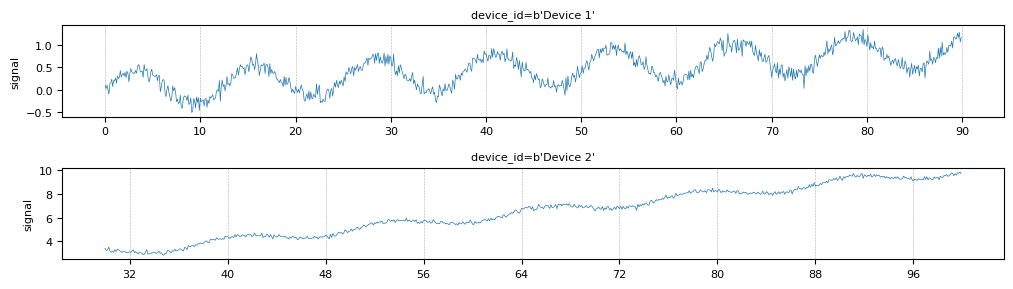

In [14]:
devices_evset["signal"].plot()

### Operations with index

Any operator that we apply now must be aware of the `index` and will be performed over each one separately.

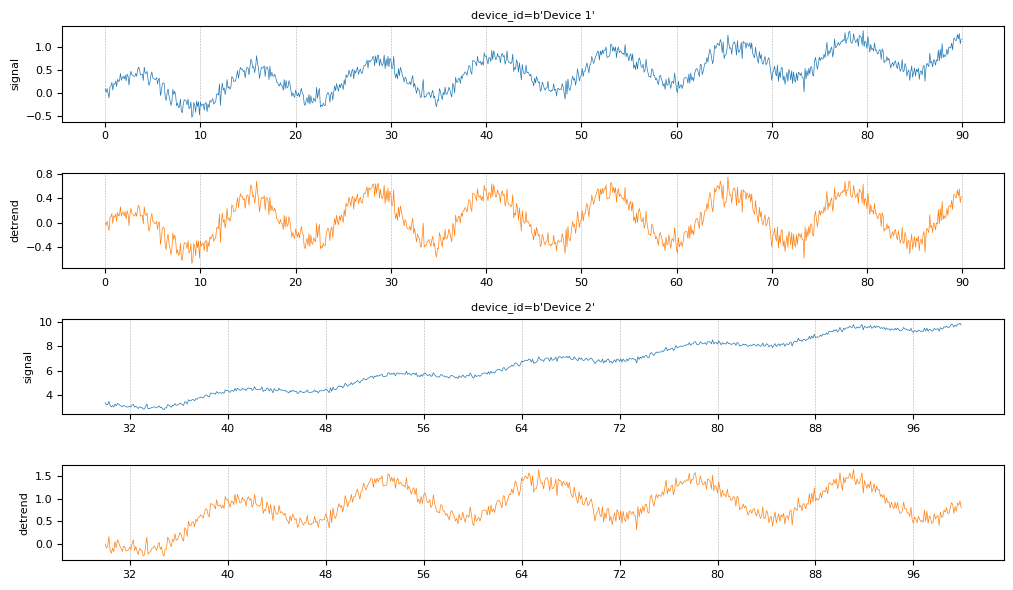

In [15]:
signal_i = devices_evset["signal"]
trend_i = signal_i.simple_moving_average(tp.duration.seconds(20))
detrend_i = signal_i - trend_i
result_i = tp.glue(signal_i, detrend_i.rename("detrend"))
result_i.plot()

### Multi-indexes

Finally, let's point out that multiple columns of the input data may be set as indexes.

For example, in the case of sales in a store, we could use both the store and product columns to group the sequences. In this case, each group would contain the sales for a single product in a single store.

This is easy to do since the `indexes` argument is actually a list of columns, and each group represented in Temporian by using a tuple `(store, product)` as the index key.

## Summary

Congratulations! You now have the basic concepts needed to create a data preprocessing pipeline with Temporian:
- Defining an **EventSet** and using **operators** on it.
- Combine **features** using **select** and **glue**.
- Coverting data back and forth between Temporian's **EventSet** and pandas **DataFrames**.
- Visualizing input/output data using **EventSet.plot()**.
- Using an **index** to separate signals in the graph operations and plots.

### What's Missing and Next Steps

There are important things we could not include in this introduction:

- In this example we used a signal with uniform sampling (equal distance between event timestamps), but Temporian can handle non-uniform data just as easily. Read more about the data representation on the **[User Guide's introduction](https://temporian.readthedocs.io/en/latest/user_guide/)**.
- Temporian is **strict on the feature types** when applying operations, to avoid potentially silent errors or memory issues. For example, you cannot perform binary operations (e.g: arithmetics or comparisons) between features with different types. Check the [User Guide's **casting** section](https://temporian.readthedocs.io/en/latest/user_guide/#casting) section to learn how to tackle those cases.
- In this case, we only used seconds as the timestamps of the signal, but you might as well use calendar dates. Learn more about it on the [**Time Units** section of the User Guide](https://temporian.readthedocs.io/en/latest/user_guide/#time-units). After reading that section, check that there are many [**calendar operators**](https://temporian.readthedocs.io/en/stable/reference/temporian/operators/calendar/calendar_day_of_month/) available when working with date timestamps.
- If you need to manipulate the timestamp of events, check the [User Guide's **sampling** section](https://temporian.readthedocs.io/en/latest/user_guide/#sampling) to learn more about this.
- We only used moving average here, but there are a bunch of other [**moving window**](https://temporian.readthedocs.io/en/stable/reference/temporian/operators/window/moving_count/) operators, frequently useful for time sequences manipulation.

Always keep in mind these resources:
- Try the more advanced [**tutorials**](https://temporian.readthedocs.io/en/latest/tutorials/) to continue learning by example about all these topics and more!
- We could only cover a small fraction of **[all available operators](https://temporian.readthedocs.io/en/stable/reference/temporian/operators/add_index/)**.
- We put a lot of ❤️ in the **[User Guide](https://temporian.readthedocs.io/en/latest/user_guide/)**, so make sure to check it out 🙂.